# Detect Anomalies Using Density Based Clustering


## Clustering-Based Anomaly Detection

- Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids. Normal data points occur around a dense neighborhood and abnormalities are far away.

- Using density based clustering, like DBSCAN, we can design the model such that the data points that do not fall into a cluster are the anomalies.

https://docs.google.com/presentation/d/1frjnm1ii63gcFSyhQxxzvekrMAAO0xnw-aitdTPIbc0/edit?usp=sharing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

import env

In [2]:
def get_curriculum_logs():
    filename = "curriculum-access.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=False)
    else:
        # read the SQL query into a dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        query = '''
        SELECT date,
               path as endpoint,
               user_id,
               cohort_id,
               ip as source_ip
        FROM logs;
        '''
        df = pd.read_sql(query, url)

        # Write that dataframe to disk for later.
        df.to_csv(filename, index = False)

        return df  

In [3]:
# acquire data using the above function
df = get_curriculum_logs()
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
# convert date to a pandas datetime format and set as index
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

Who is accessing the curriculum a lot (total views) and possibiliy looking at lot of unique pages (scraping?) 

Aggregate and compute 2 features...number of unique pages and total page views. 

In [5]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
date,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [6]:
page_views = df.groupby(['user_id'])['endpoint'].agg(['count', 'nunique'])
page_views

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


Scale each attribute linearly. 

In [7]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
page_views_scaled_array = scaler.transform(page_views)
page_views_scaled_array[0:10]

array([[0.41329835, 1.        ],
       [0.08597588, 0.15384615],
       [0.08714828, 0.17230769],
       [0.03857749, 0.14564103],
       [0.09490844, 0.20102564],
       [0.07855069, 0.22974359],
       [0.10060295, 0.17435897],
       [0.02690933, 0.09128205],
       [0.03260384, 0.14871795],
       [0.05141804, 0.14666667]])

Construct a DBSCAN object that requires a minimum of 4 data points in a neighborhood of radius 0.1 to be considered a core point.

In [8]:
page_views.shape

(981, 2)

In [9]:
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(page_views_scaled_array)
print(dbsc)

DBSCAN(eps=0.1, min_samples=4)


In [10]:
# Now, let's add the scaled value columns back onto the dataframe

columns = list(page_views.columns)
scaled_columns = ["scaled_" + column for column in columns]
scaled_columns

['scaled_count', 'scaled_nunique']

In [11]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(page_views_scaled_array, columns=scaled_columns, index=page_views.index)
scaled_df.head()

,scaled_count,scaled_nunique
user_id,,
1,0.413298,1.000000
2,0.085976,0.153846
3,0.087148,0.172308
4,0.038577,0.145641
5,0.094908,0.201026


In [12]:
page_views.head()

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197


In [13]:
# Merge the scaled and non-scaled values into one dataframe
page_views = page_views.merge(scaled_df, left_index=True, right_index=True)
page_views

,count,nunique,scaled_count,scaled_nunique
user_id,,,,
1,7404,976,0.413298,1.000000
2,1541,151,0.085976,0.153846
3,1562,169,0.087148,0.172308
4,692,143,0.038577,0.145641
5,1701,197,0.094908,0.201026
...,...,...,...,...
977,86,12,0.004745,0.011282
978,55,18,0.003015,0.017436
979,127,20,0.007034,0.019487


In [14]:
labels = dbsc.labels_

In [15]:
labels[0:15]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0])

#### label '-1' represents observations which are not part of any cluster and are potential anomalies warranting further investigation

In [16]:
#add labels back to the dataframe
page_views['labels'] = labels

# how many unique labels (clusters) are created by DBSCAN?
page_views.labels.value_counts()

 0    976
-1      5
Name: labels, dtype: int64

In [17]:
page_views[page_views.labels==-1]

,count,nunique,scaled_count,scaled_nunique,labels
user_id,,,,,
1,7404,976,0.413298,1.000000,-1
11,17913,871,1.000000,0.892308,-1
53,12329,333,0.688254,0.340513,-1
64,16347,437,0.912573,0.447179,-1
248,5075,625,0.283274,0.640000,-1


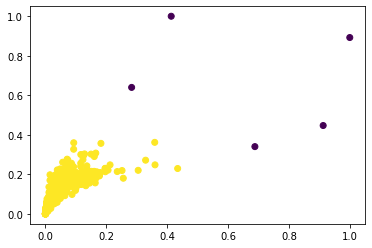

In [18]:
plt.scatter(page_views['scaled_count'], page_views['scaled_nunique'], c=page_views.labels)
plt.show()

## Experiment with the DBSCAN properties
- Read up on the epsilon and min_samples arguments into DBSCAN at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- Experiment with altering the epsilon values (the `eps` argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?
- Double the `min_samples` parameter. Run your model and visualize the results. Consider what changed and why.

# Exercise

**file name:** clustering_anomaly_detection.py or clustering_anomaly_detection.ipynb


### Clustering - DBSCAN

Ideas: 

Use DBSCAN to detect anomalies in curriculumn access. 

Use DBSCAN to detect anomalies in other products from the customers dataset. 

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).
